In [65]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from os.path import join

# plt.style.use(['science', 'ieee', 'no-latex'])
sns.set_style("ticks")
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.family"] = "Times New Roman"

RESULTS_DIR = "results"
HUE_ORDER = ["Federated", "Centralized", "Decentralized"]
STYLE_ORDER = ["Federated", "Centralized", "Decentralized"]
NETFILES = ['Grid-3x3', 'Grid-5x5', 'Grid-7x7']
EXPERIMENTS_DIR = ("..", "out", "experiments", "smartcomp-digital")
REPLACE_DICT = {
    # Netfile names
    "grid-3x3": "Grid-3x3",
    "grid-5x5": "Grid-5x5",
    "grid-7x7": "Grid-7x7",

    # Trainer names
    "FedRL": "Federated",
    "MARL": "Decentralized",
    "SARL": "Centralized"
}

In [66]:
rewards_df = pd.read_csv(join(*EXPERIMENTS_DIR, "rewards.csv"))
rewards_df.replace(REPLACE_DICT, inplace=True)
rewards_df.head()

Unnamed: 0 tls_id  reward   netfile  step  n_vehicles  \
0           0     A0    -0.0  Grid-3x3     1           0   
1           1     A1    -0.0  Grid-3x3     1           0   
2           2     A2    -0.0  Grid-3x3     1           0   
3           3     B0    -0.0  Grid-3x3     1           0   
4           4     B1    -0.0  Grid-3x3     1           0   

                          policy    trainer trainer_intersection  \
0  v4_pos-reward-aggr_ranked.pkl  Federated             Grid-3x3   
1  v4_pos-reward-aggr_ranked.pkl  Federated             Grid-3x3   
2  v4_pos-reward-aggr_ranked.pkl  Federated             Grid-3x3   
3  v4_pos-reward-aggr_ranked.pkl  Federated             Grid-3x3   
4  v4_pos-reward-aggr_ranked.pkl  Federated             Grid-3x3   

  trainer_ranked  mc_run  
0         ranked       0  
1         ranked       0  
2         ranked       0  
3         ranked       0  
4         ranked       0

In [67]:
features_df = pd.read_csv(join(*EXPERIMENTS_DIR, "features.csv"))
features_df.replace(REPLACE_DICT, inplace=True)
features_df.head()

Unnamed: 0         feature  value   netfile tls  \
0           0  lane_occupancy    0.0  Grid-3x3  A0   
1           1  lane_occupancy    0.0  Grid-3x3  A1   
2           2  lane_occupancy    0.0  Grid-3x3  A2   
3           3  lane_occupancy    0.0  Grid-3x3  B0   
4           4  lane_occupancy    0.0  Grid-3x3  B1   

                          policy  ranked    trainer trainer_intersection  \
0  v4_pos-reward-aggr_ranked.pkl    True  Federated             Grid-3x3   
1  v4_pos-reward-aggr_ranked.pkl    True  Federated             Grid-3x3   
2  v4_pos-reward-aggr_ranked.pkl    True  Federated             Grid-3x3   
3  v4_pos-reward-aggr_ranked.pkl    True  Federated             Grid-3x3   
4  v4_pos-reward-aggr_ranked.pkl    True  Federated             Grid-3x3   

  trainer_ranked  mc_run  
0         ranked       0  
1         ranked       0  
2         ranked       0  
3         ranked       0  
4         ranked       0

In [68]:
trips_df = pd.read_csv(join(*EXPERIMENTS_DIR, "tripinfo.csv"))
trips_df.replace(REPLACE_DICT, inplace=True)
trips_df.head()

Unnamed: 0    trainer trainer_intersection trainer_ranked  depart_delay  \
0           0  Federated             Grid-3x3         ranked          0.38   
1           1  Federated             Grid-3x3         ranked          0.66   
2           2  Federated             Grid-3x3         ranked          0.50   
3           3  Federated             Grid-3x3         ranked          0.25   
4           4  Federated             Grid-3x3         ranked          0.16   

   travel_time  route_length  waiting_time  waiting_count  reroute_number  \
0         34.0         184.5           3.0              1               0   
1         53.0         394.9           9.0              1               0   
2         62.0         394.9          14.0              2               0   
3         67.0         394.9          24.0              2               0   
4         66.0         394.9          16.0              3               0   

   mc_run  
0       0  
1       0  
2       0  
3       0  
4       0

In [69]:
rewards_df["reward"].describe()

count    753131.000000
mean         -0.002063
std           0.014292
min          -0.886951
25%          -0.001545
50%          -0.000377
75%          -0.000000
max          -0.000000
Name: reward, dtype: float64

In [70]:
matrices = {}
for trainer in rewards_df["trainer"].unique():
    for ranked in ["ranked", "unranked"]:
        matrix = []
        for trained_on in NETFILES:
            row = []
            for evaled_on in NETFILES:
                q = f"trainer == '{trainer}' and trainer_ranked == '{ranked}' and " \
                    f"trainer_intersection == '{trained_on}' and netfile == '{evaled_on}'"
                query = rewards_df.query(q)
                row.append(query["reward"].mean())
            matrix.append(row)
        matrices[trainer, ranked] = np.array(matrix)

matrices.keys()

dict_keys([('Federated', 'ranked'), ('Federated', 'unranked'), ('Decentralized', 'ranked'), ('Decentralized', 'unranked'), ('Centralized', 'ranked'), ('Centralized', 'unranked')])

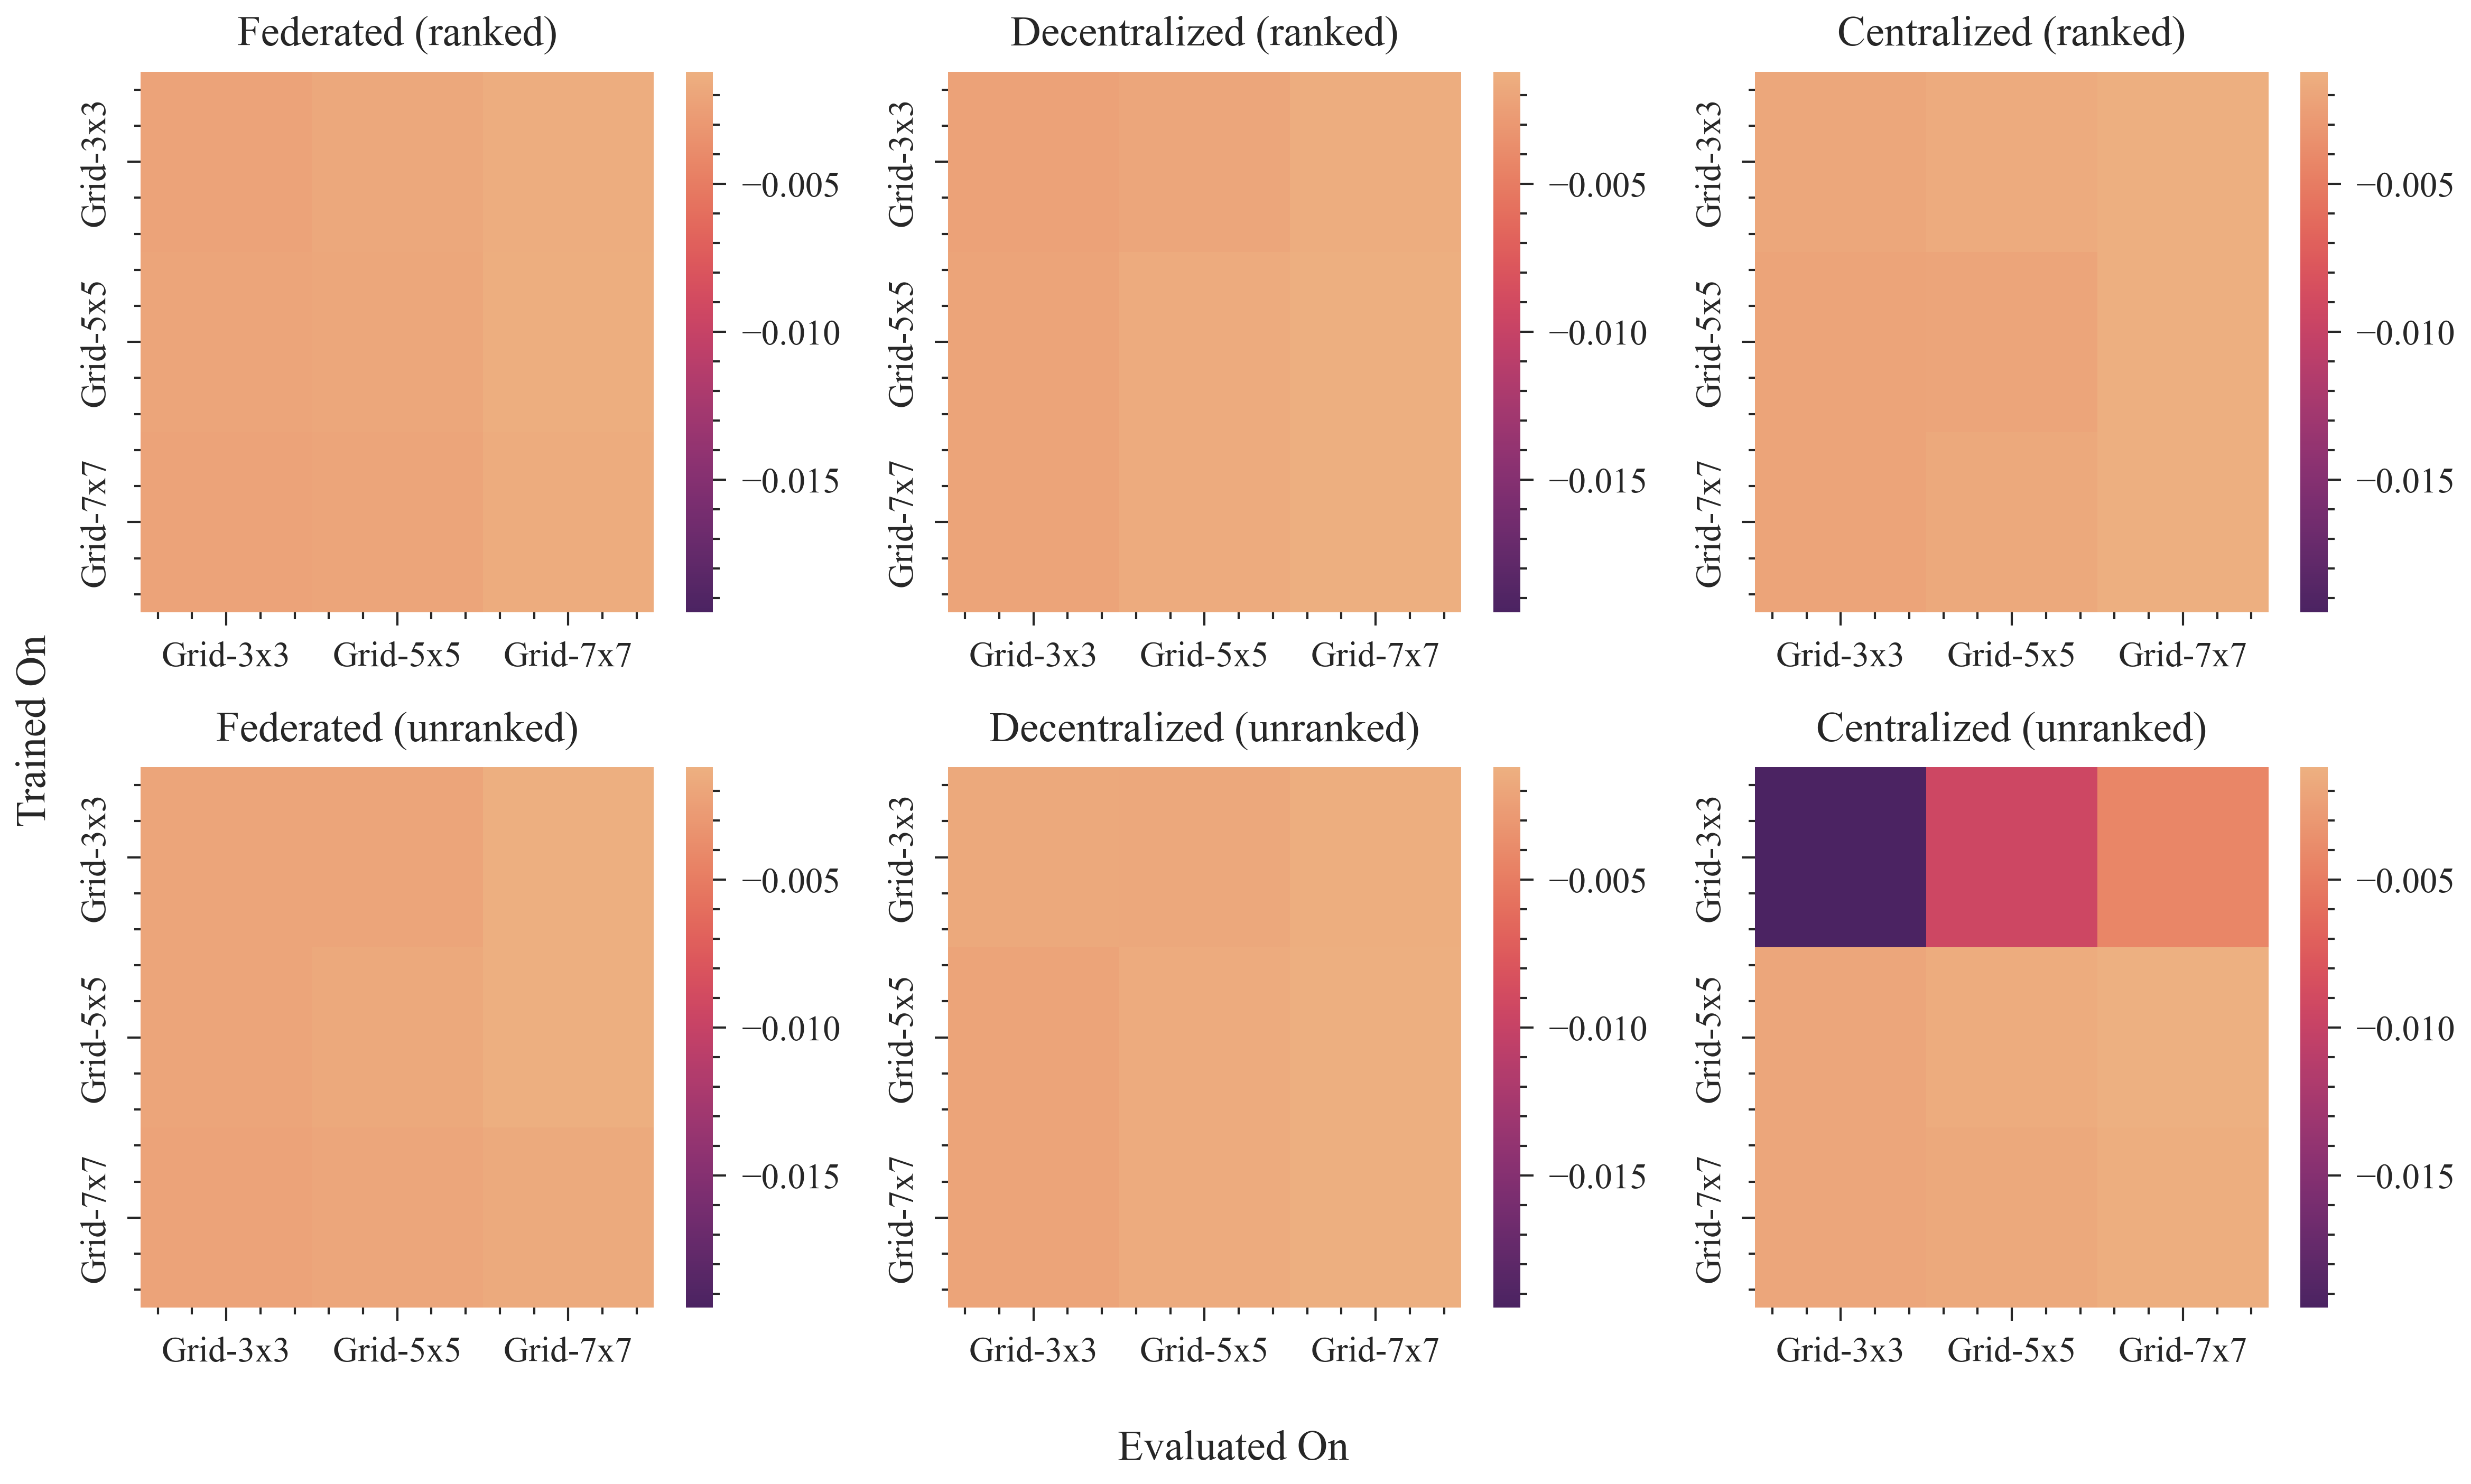

In [71]:
RANKS = ["ranked", "unranked"]
TRAINERS = ["Federated", "Decentralized", "Centralized"]

vmin, vmax = float("inf"), float("-inf")
for matrix in matrices.values():
    mat = matrix.flatten()
    vmin = min(vmin, mat.min())
    vmax = max(vmax, mat.max())
    
fig, axes = plt.subplots(nrows=len(RANKS), ncols=len(TRAINERS), figsize=(8, 4.75))

for row, ranked in enumerate(RANKS):
    for col, trainer in enumerate(TRAINERS):
        f = sns.heatmap(
            matrices[trainer, ranked],
            xticklabels=NETFILES,
            yticklabels=NETFILES,
            vmin=vmin,
            vmax=vmax,
            cmap="flare_r",
            ax=axes[row, col]
        )
        axes[row, col].set_title(f"{trainer} ({ranked})")

fig.supylabel("Trained On")
fig.supxlabel("Evaluated On")
plt.tight_layout()
plt.show()

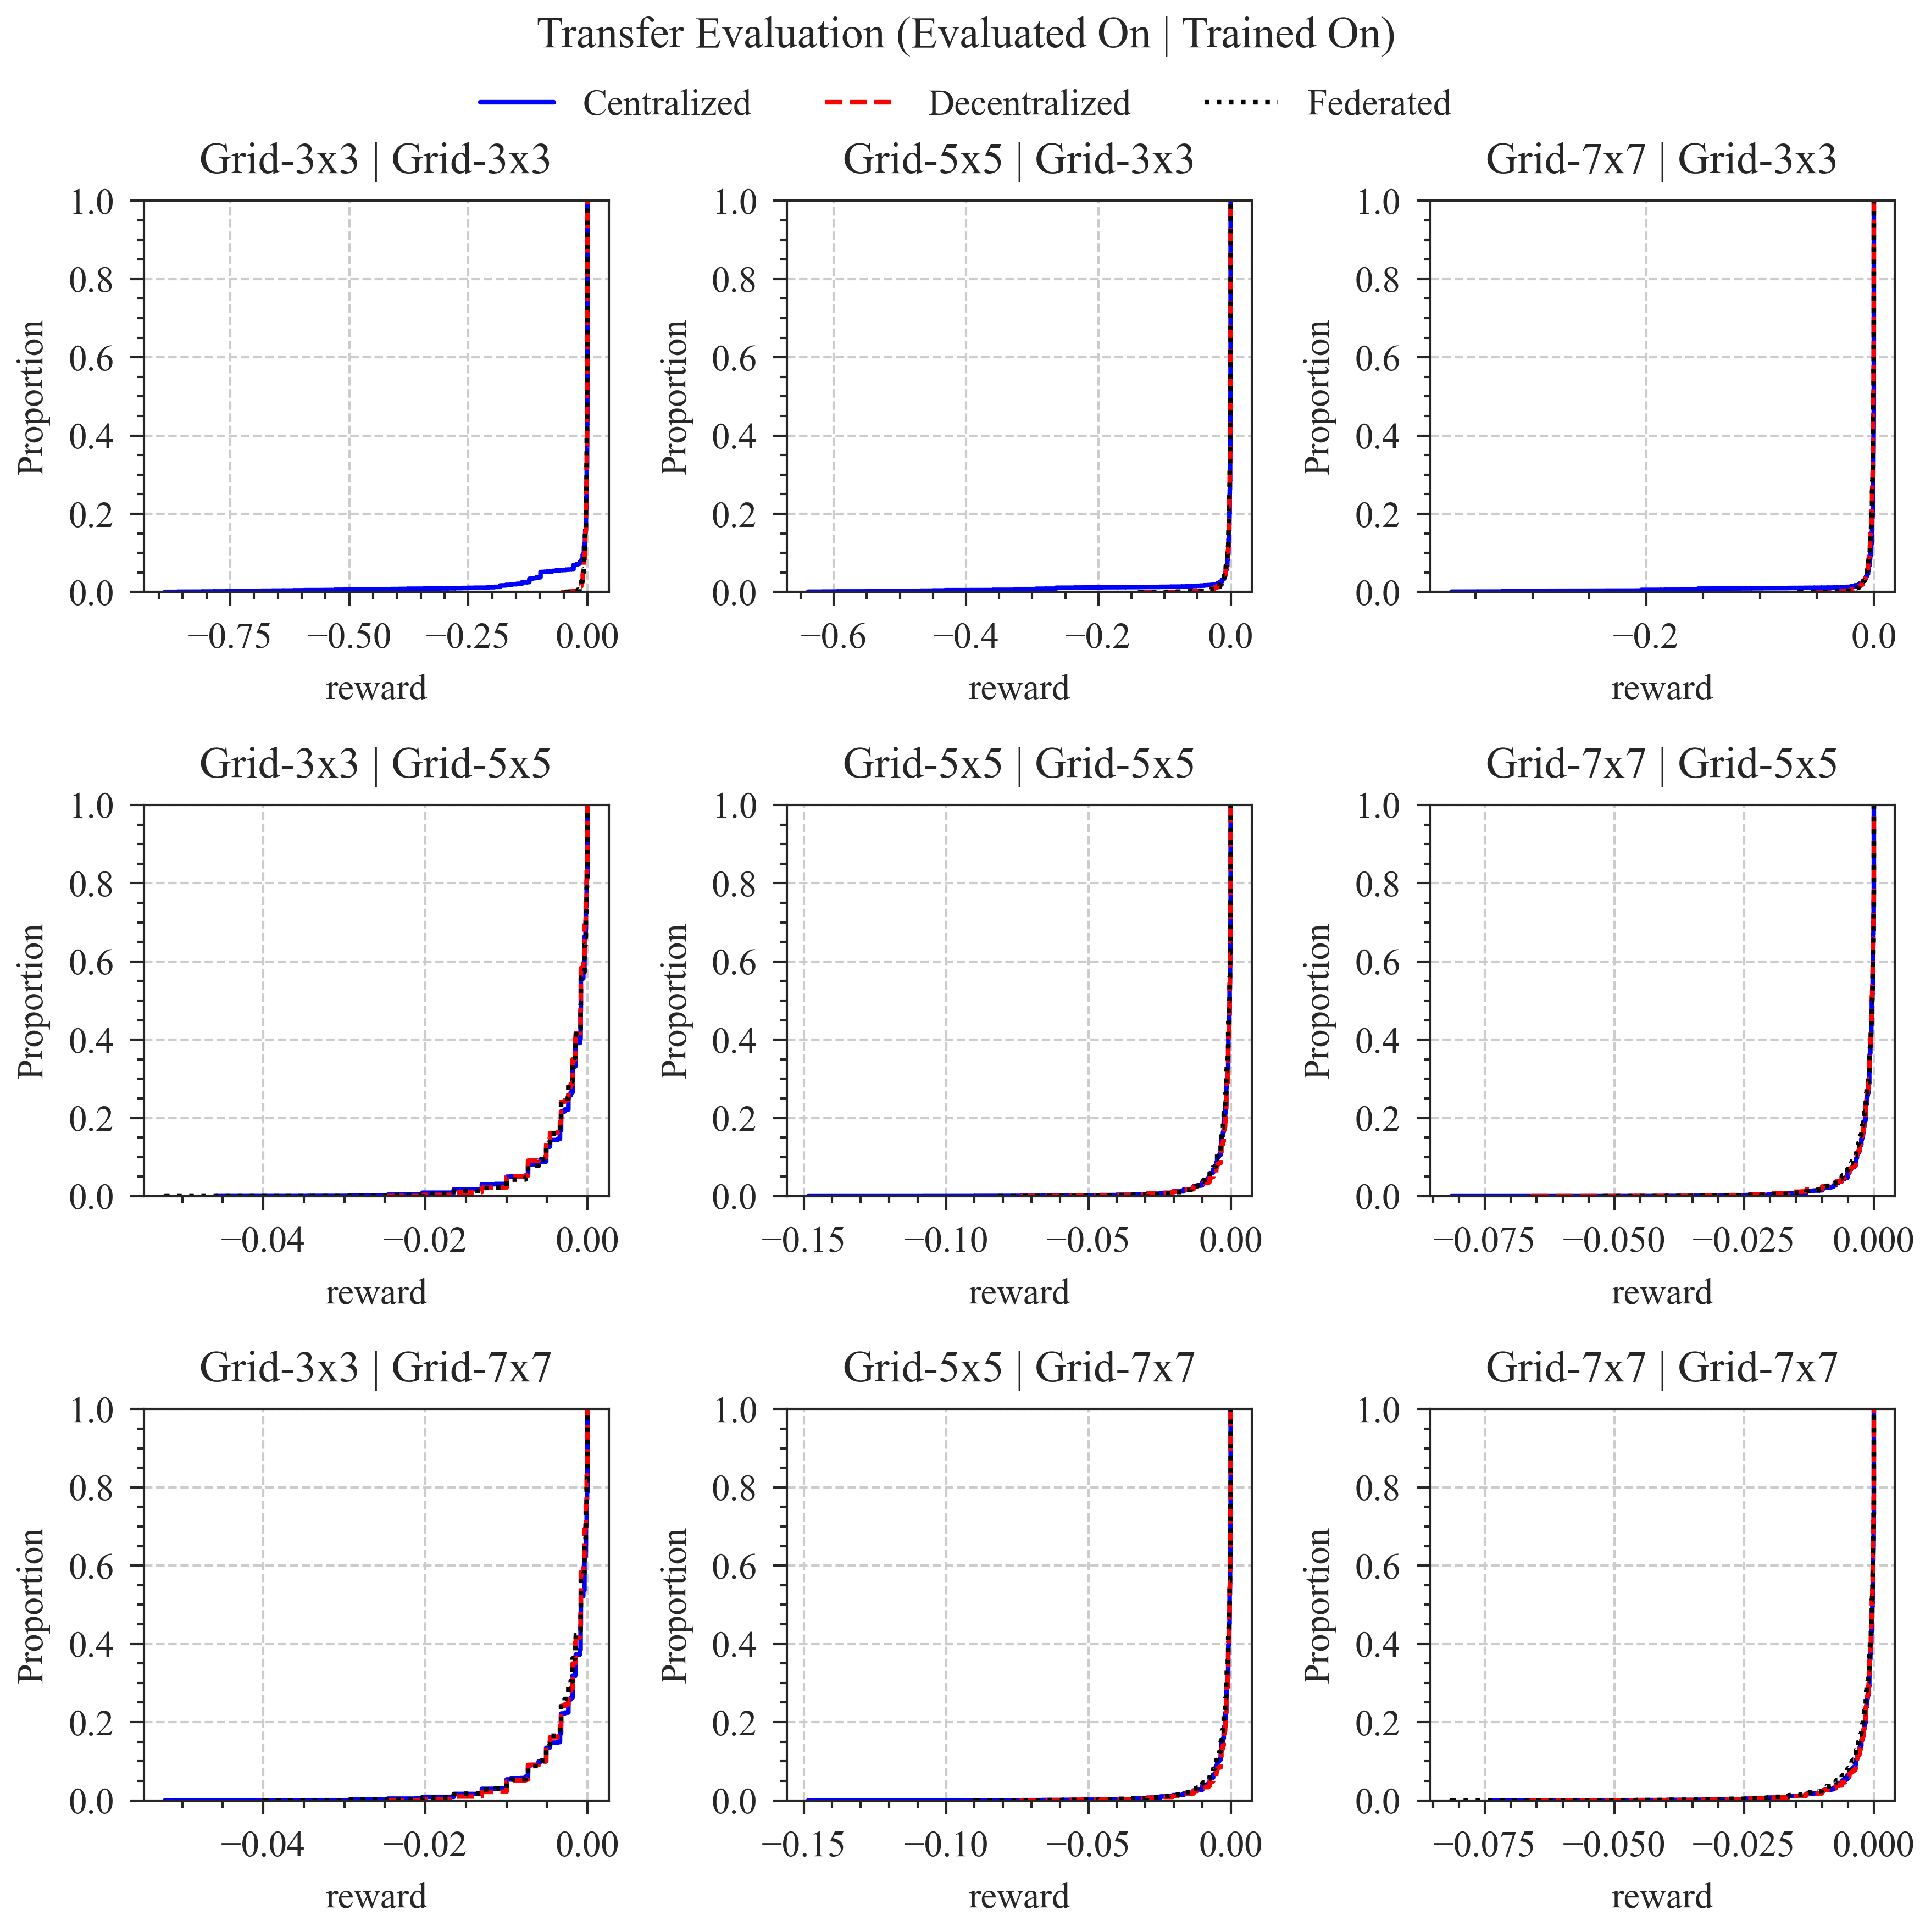

In [72]:
fig, ax = plt.subplots(nrows=len(NETFILES), ncols=len(NETFILES), figsize=(6, 6))
for row, trained_on in enumerate(NETFILES):
    for col, eval_on in enumerate(NETFILES):
        q = f"trainer_intersection == '{trained_on}' and netfile == '{eval_on}'"
        sns.ecdfplot(
            data=rewards_df.query(q), 
            x="reward",
            hue="trainer", 
            ax=ax[row, col],
            # multiple="fill",
        )#.set(yscale="log")
        ax[row, col].set_title(f"{eval_on} | {trained_on}")
        ax[row, col].grid(which="major", linestyle="--")
        children = ax[row, col].get_children()
        # if not (row == len(NETFILES) - 1 and col == len(NETFILES) - 1):
        #     ax[row, col].get_legend().remove()
        ax[row, col].get_legend().remove()

handles = [child for child in children if isinstance(child, mpl.lines.Line2D)]
labels = ["Centralized", "Decentralized", "Federated"]
fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 0.96))
plt.suptitle("Transfer Evaluation (Evaluated On | Trained On)\n")
plt.tight_layout()
plt.show()

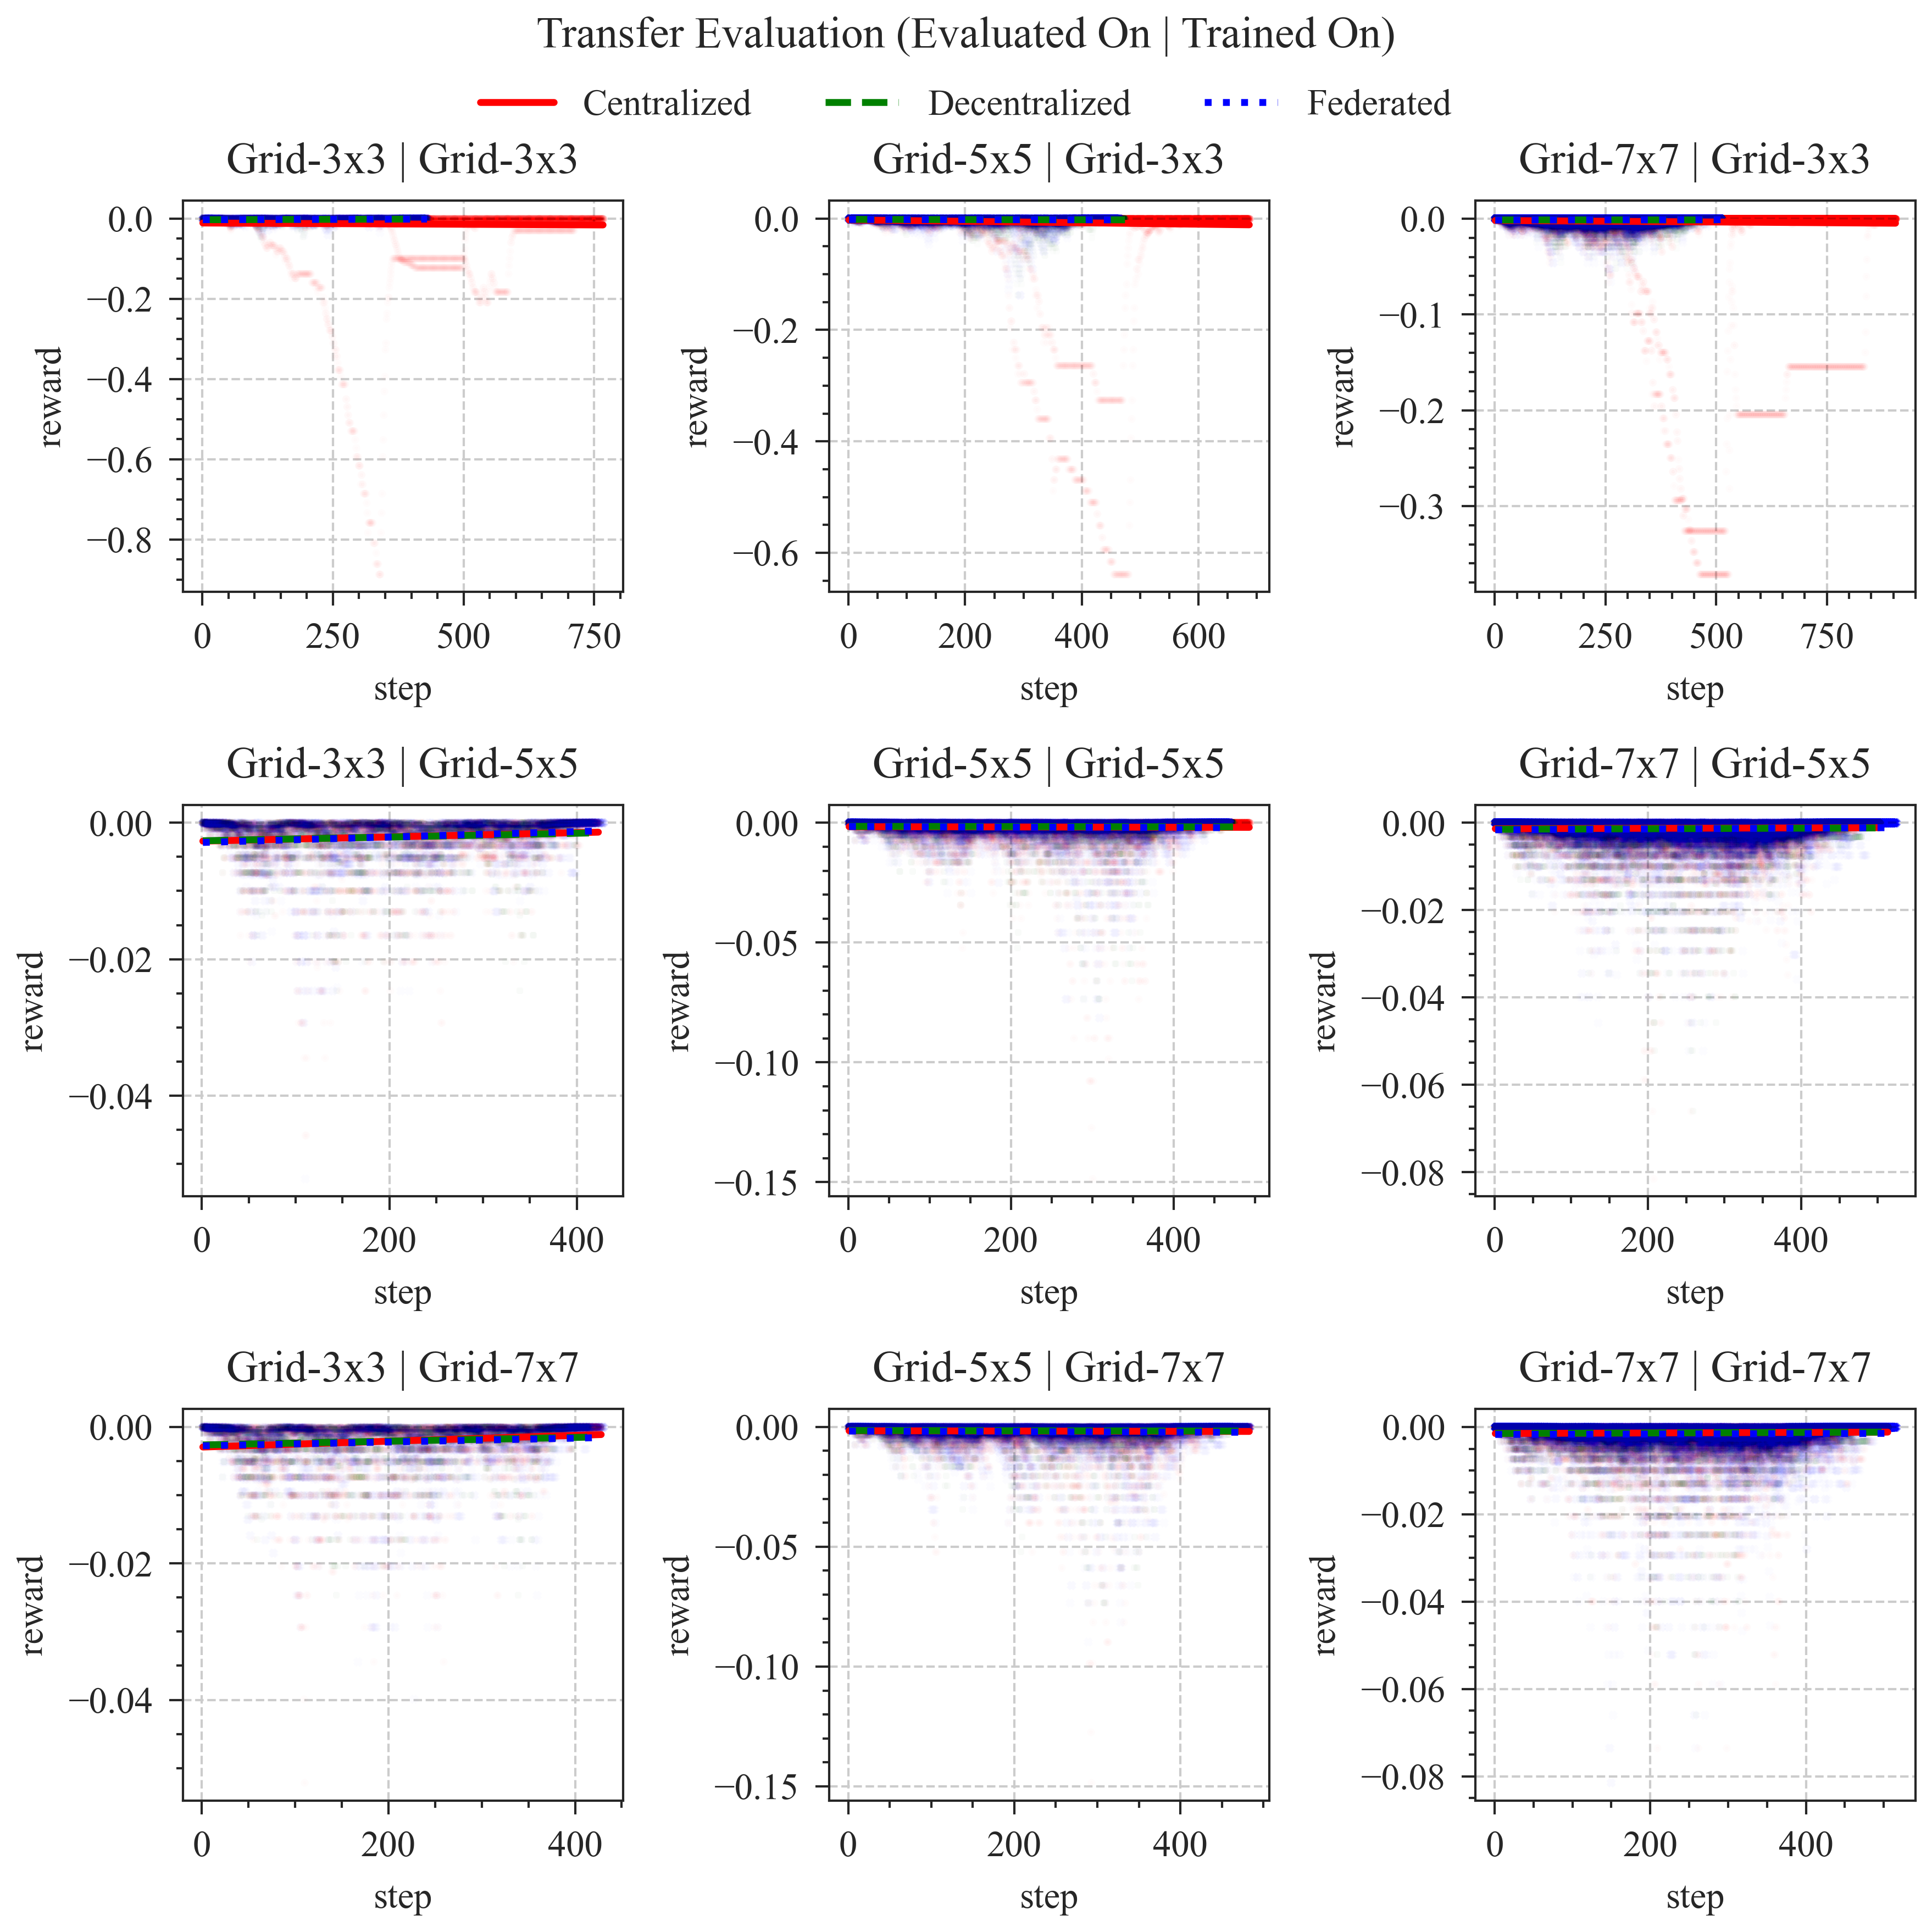

In [73]:
trainers = ["Centralized", "Decentralized", "Federated"]
colors = ["r", "g", "b"]
markers = [".", "+", "x"]

fig, ax = plt.subplots(nrows=len(NETFILES), ncols=len(NETFILES), figsize=(6, 6))
for row, trained_on in enumerate(NETFILES):
    for col, eval_on in enumerate(NETFILES):
        for trainer, color, marker in zip(trainers, colors, markers):
            q = f"trainer_intersection == '{trained_on}' and netfile == '{eval_on}' and trainer == '{trainer}'"
            sns.regplot(
                data=rewards_df.query(q), 
                x="step",
                y="reward",
                color=color,
                ax=ax[row, col],
                label=trainer,
                marker=marker,
                scatter_kws={"s": 2, "alpha": 0.01},
                ci=None
            )
        ax[row, col].set_title(f"{eval_on} | {trained_on}")
        ax[row, col].grid(which="major", linestyle="--")
        children = ax[row, col].get_children()
        # if (row == len(NETFILES) - 1 and col == len(NETFILES) - 1):
        #     ax[row, col].legend(loc="best")

handles = [child for child in children if isinstance(child, mpl.lines.Line2D)]
labels = ["Centralized", "Decentralized", "Federated"]
fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 0.96))
plt.suptitle("Transfer Evaluation (Evaluated On | Trained On)\n")
plt.tight_layout()
plt.show()

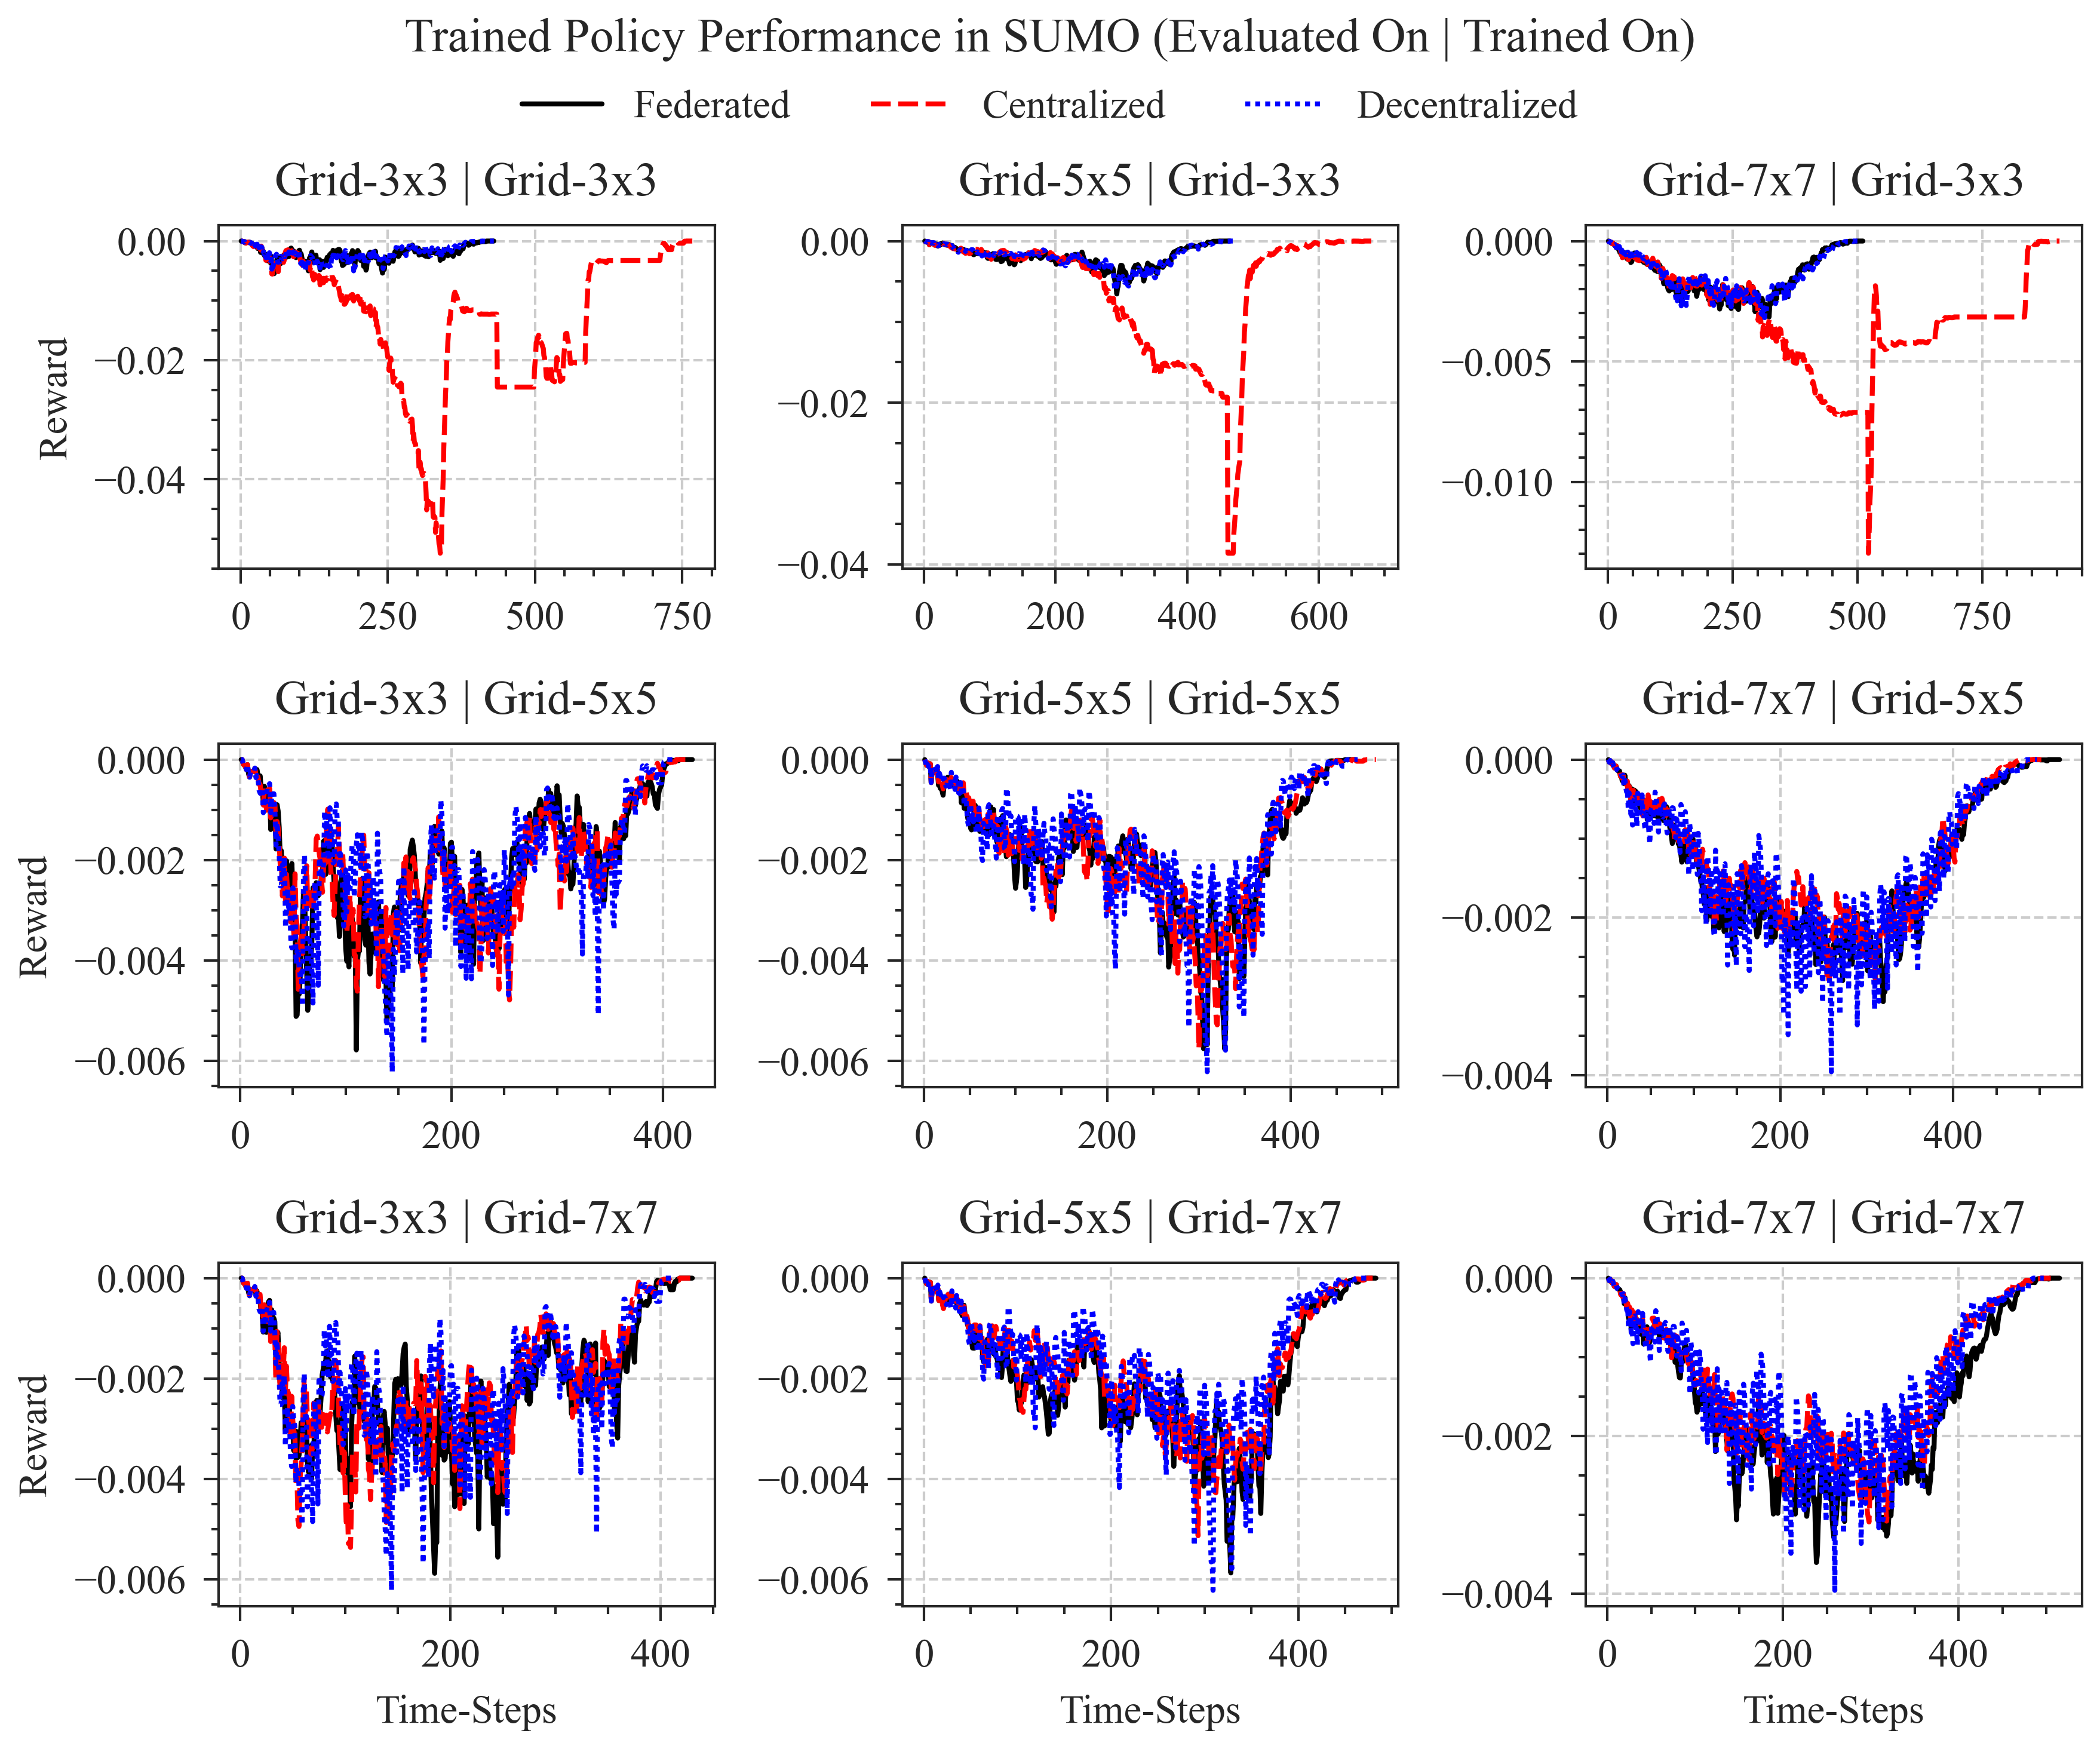

In [74]:
trainers = ["Centralized", "Decentralized", "Federated"]
colors = ["r", "g", "b"]
markers = [".", "+", "x"]

fig, ax = plt.subplots(nrows=len(NETFILES), ncols=len(NETFILES), figsize=(6, 5))
for row, trained_on in enumerate(NETFILES):
    for col, eval_on in enumerate(NETFILES):
        q = f"trainer_intersection == '{trained_on}' and netfile == '{eval_on}'"
        sns.lineplot(
            data=rewards_df.query(q), 
            x="step",
            y="reward",
            hue="trainer",
            style="trainer",
            hue_order=HUE_ORDER,
            style_order=STYLE_ORDER,
            ax=ax[row, col],
            ci=None
        )

        ax[row, col].set_title(f"{eval_on} | {trained_on}")
        ax[row, col].grid(which="major", linestyle="--")
        children = ax[row, col].get_children()
        ax[row, col].get_legend().remove()
        # if (row == len(NETFILES) - 1 and col == len(NETFILES) - 1):
        #     ax[row, col].legend(loc="best")

        if col == 0:
            ax[row, col].set_ylabel("Reward")
        else:
            ax[row, col].set_ylabel("")

        if row == len(NETFILES) - 1:
            ax[row, col].set_xlabel("Time-Steps")
        else:
            ax[row, col].set_xlabel("")

handles = [child for child in children if isinstance(child, mpl.lines.Line2D)]
labels = HUE_ORDER
fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 0.96))
plt.suptitle("Trained Policy Performance in SUMO (Evaluated On | Trained On)\n")
plt.tight_layout()
plt.savefig(join(RESULTS_DIR, "sumo_eval_plots.pdf"))
plt.show()

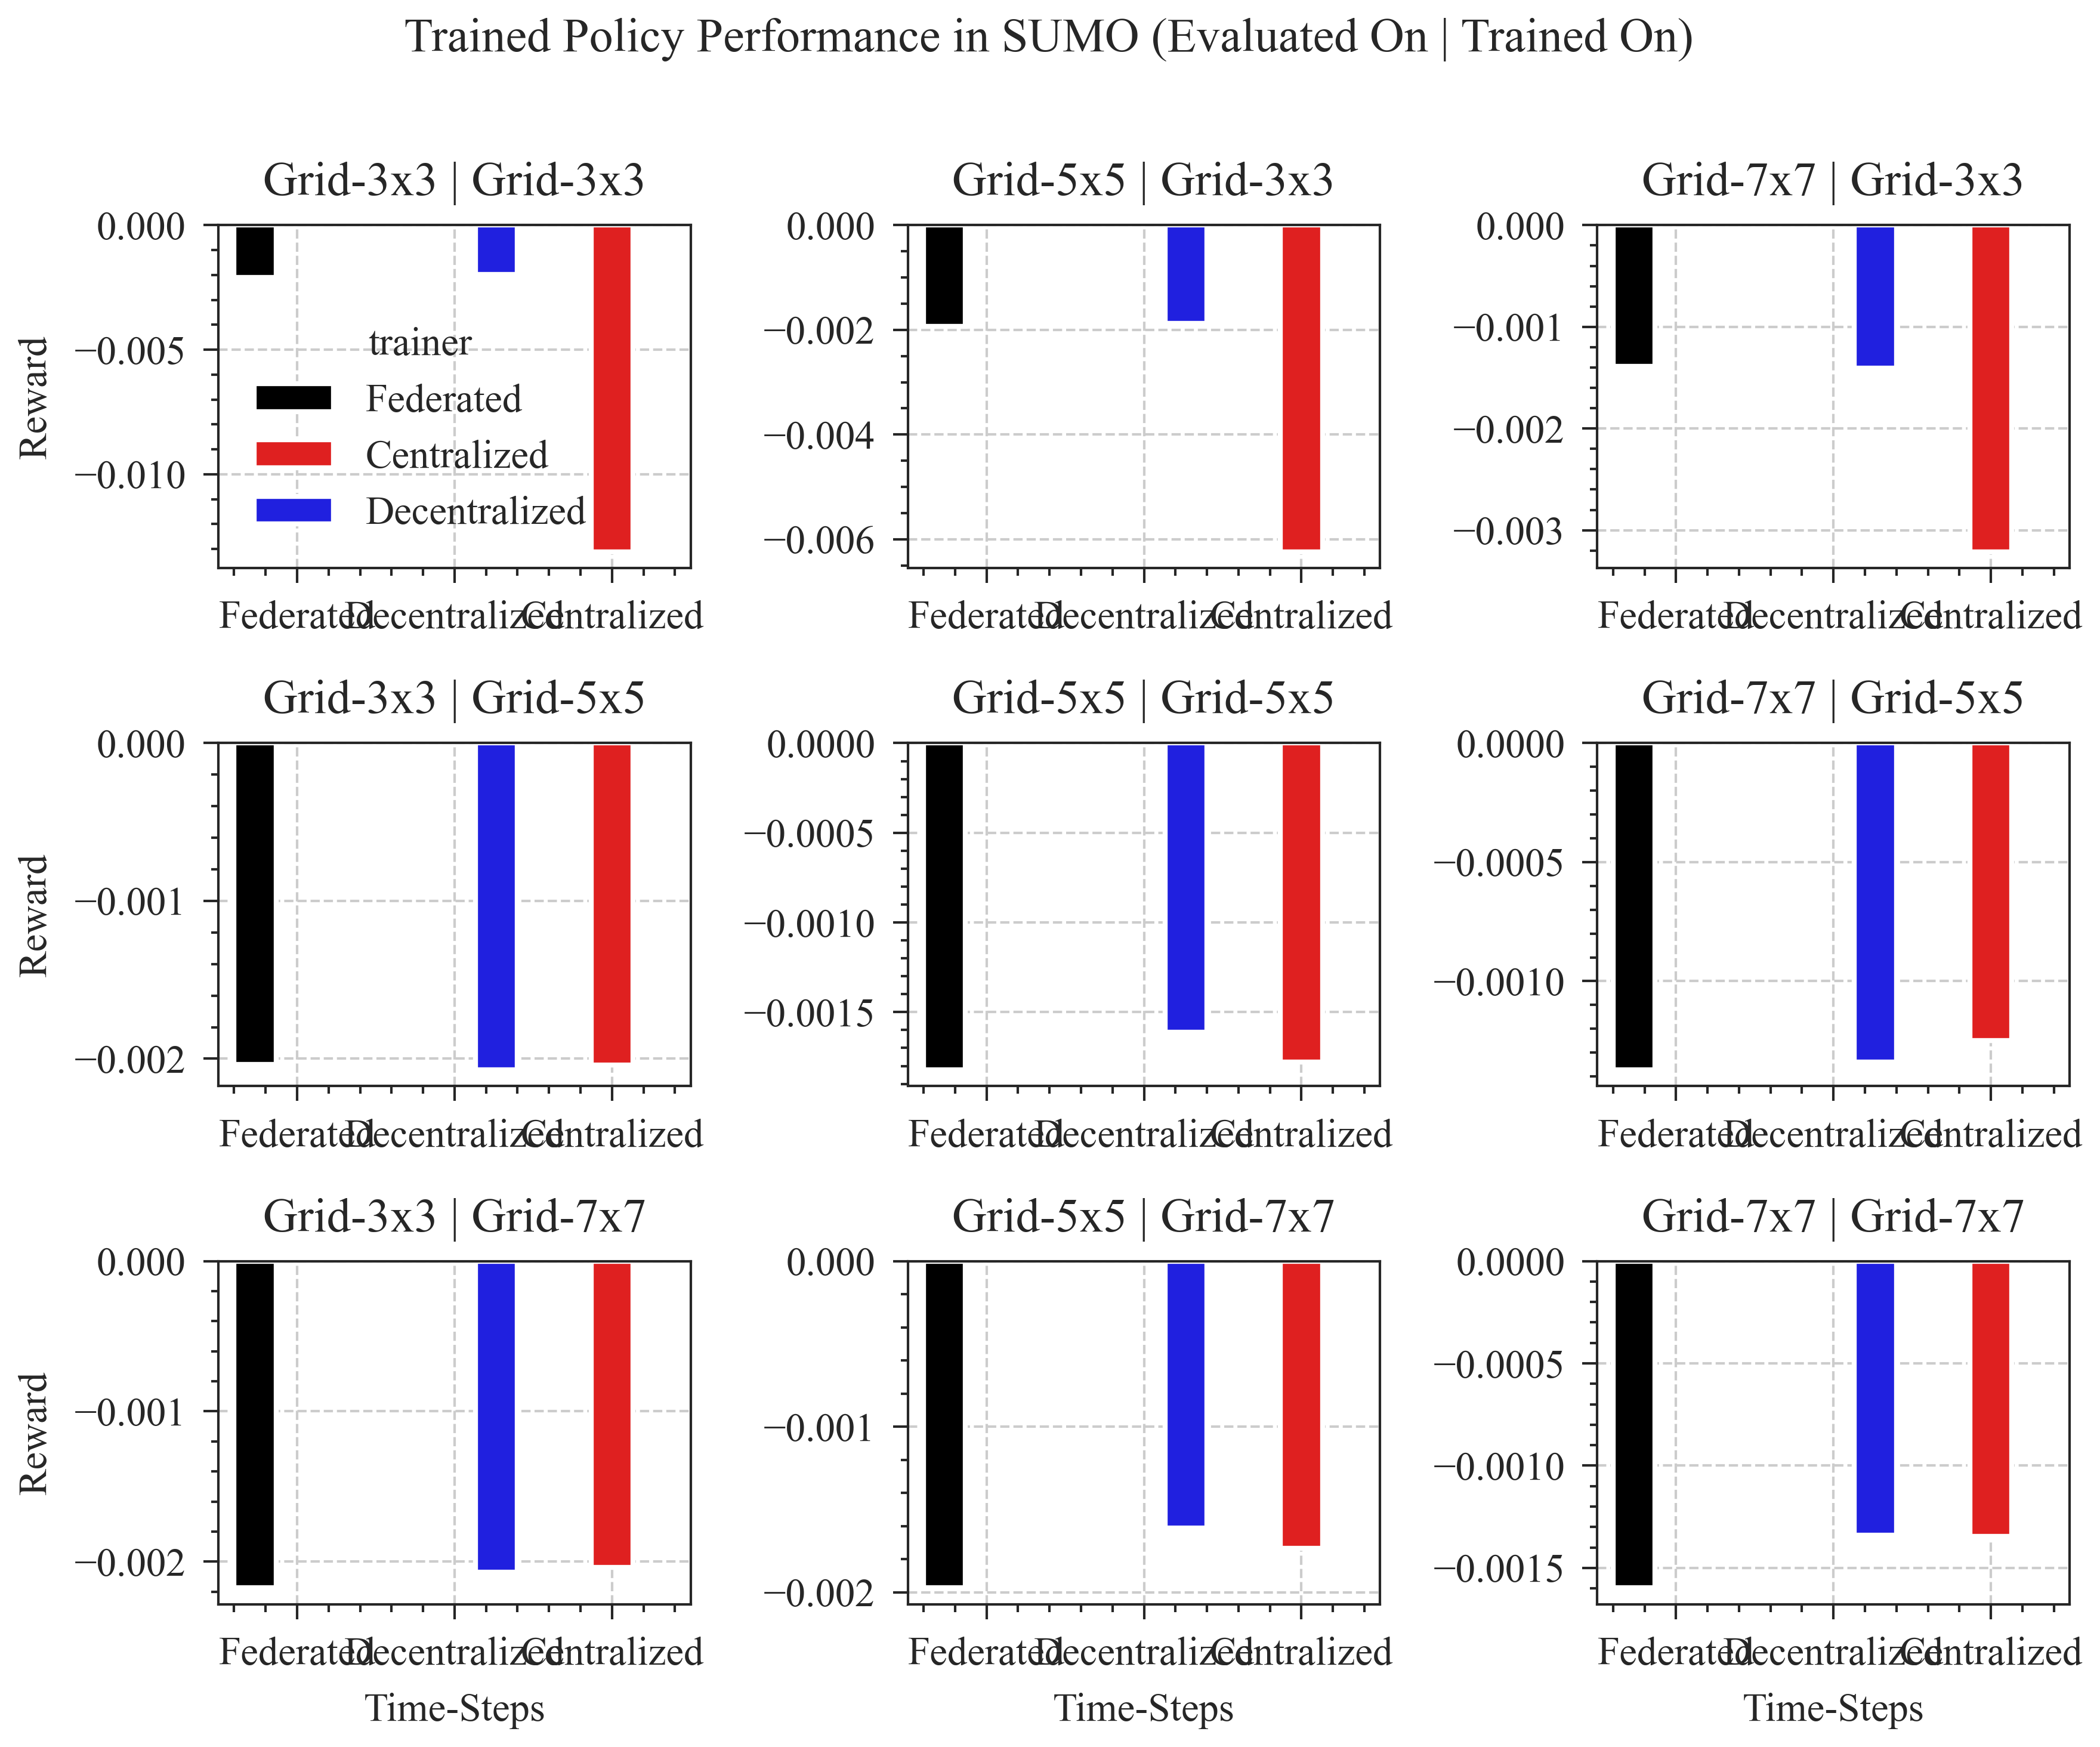

In [75]:
trainers = ["Centralized", "Decentralized", "Federated"]
colors = ["r", "g", "b"]
markers = [".", "+", "x"]

fig, ax = plt.subplots(nrows=len(NETFILES), ncols=len(NETFILES), figsize=(6, 5))
for row, trained_on in enumerate(NETFILES):
    for col, eval_on in enumerate(NETFILES):
        q = f"trainer_intersection == '{trained_on}' and netfile == '{eval_on}'"
        sns.barplot(
            data=rewards_df.query(q),
            x="trainer",
            y="reward",
            hue="trainer",
            # style="trainer",
            hue_order=HUE_ORDER,
            # style_order=STYLE_ORDER,
            ax=ax[row, col],
            ci=None
        )

        ax[row, col].set_title(f"{eval_on} | {trained_on}")
        ax[row, col].grid(which="major", linestyle="--")
        children = ax[row, col].get_children()
        if not (row == 0 and col == 0):
            ax[row, col].get_legend().remove()
        # if (row == len(NETFILES) - 1 and col == len(NETFILES) - 1):
        #     ax[row, col].legend(loc="best")

        if col == 0:
            ax[row, col].set_ylabel("Reward")
        else:
            ax[row, col].set_ylabel("")

        if row == len(NETFILES) - 1:
            ax[row, col].set_xlabel("Time-Steps")
        else:
            ax[row, col].set_xlabel("")

handles = [child for child in children if isinstance(child, mpl.lines.Line2D)]
labels = HUE_ORDER
fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 0.96))
plt.suptitle("Trained Policy Performance in SUMO (Evaluated On | Trained On)\n")
plt.tight_layout()
plt.savefig(join(RESULTS_DIR, "sumo_eval_plots.pdf"))
plt.show()

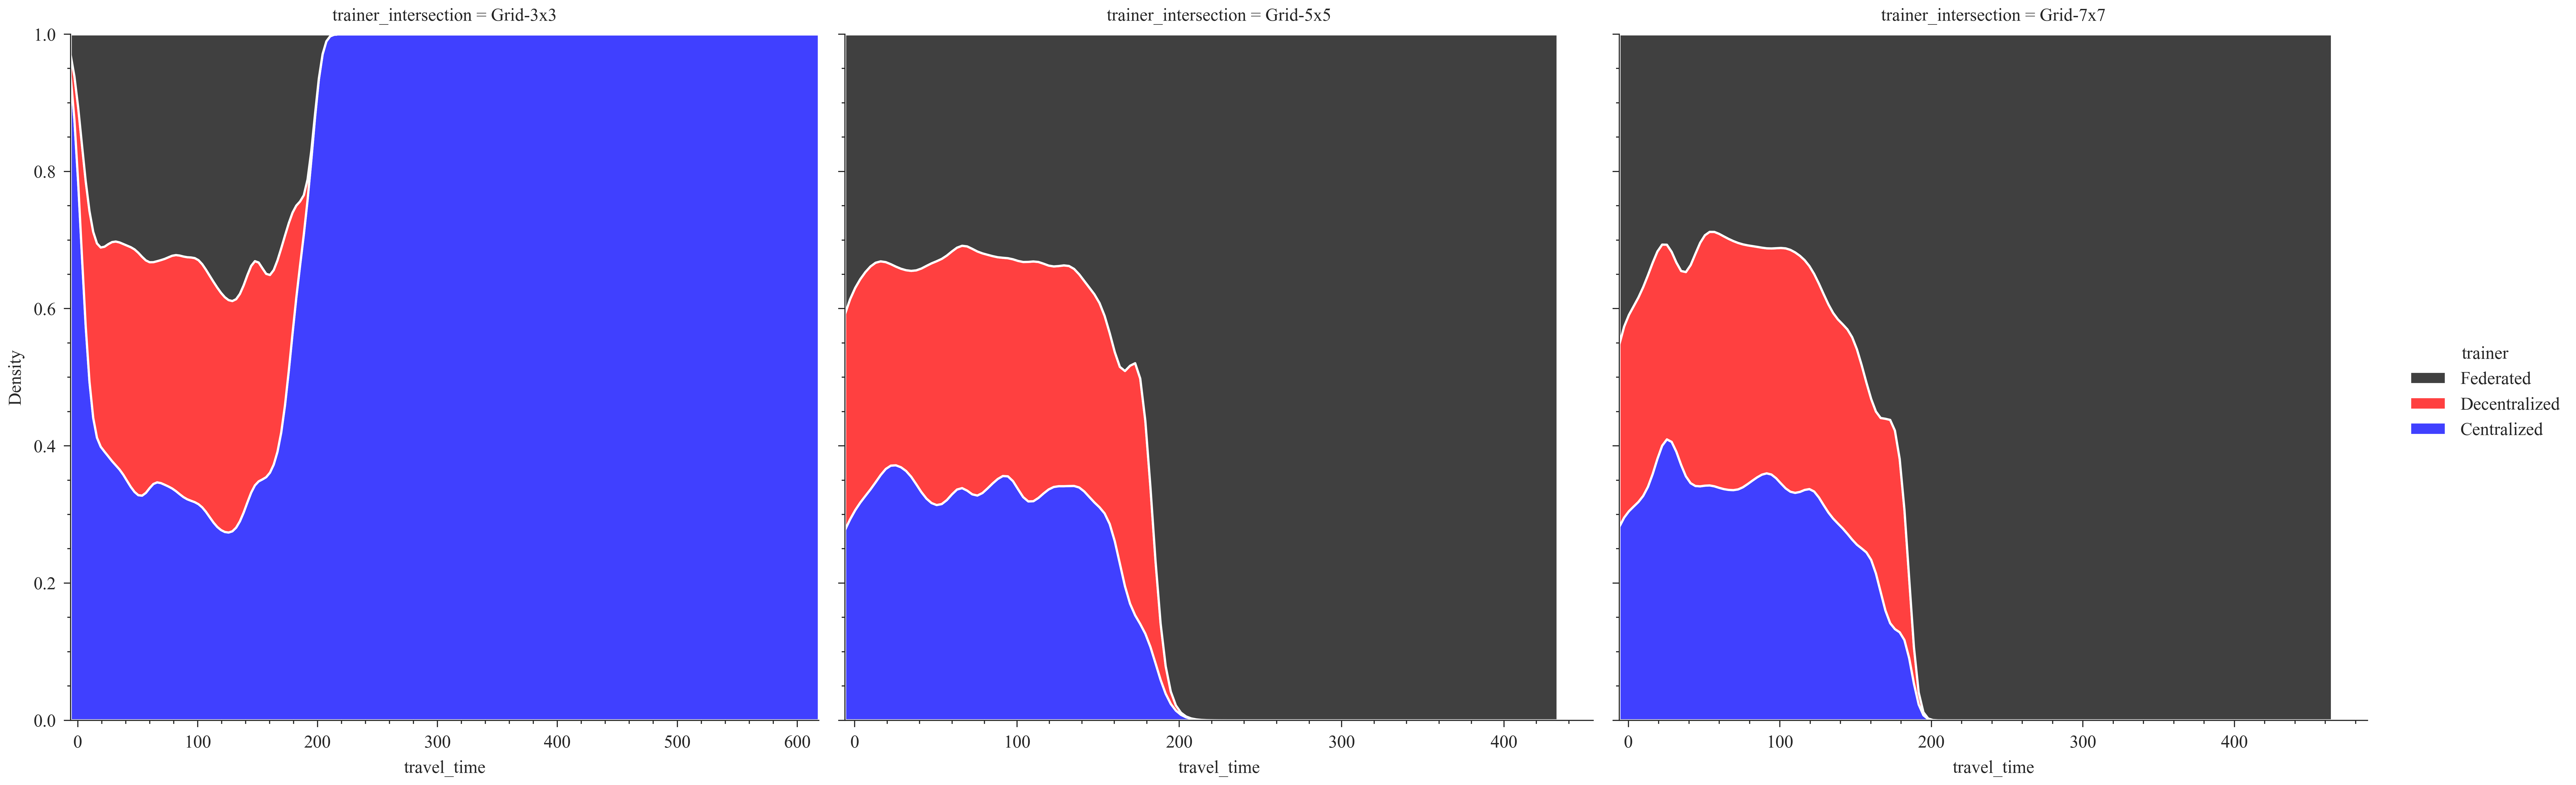

In [86]:
sns.displot(
    data=trips_df,
    kind="kde",
    hue="trainer",
    x="travel_time",
    multiple="fill",
    # y="travel_time",
    # col="netfile",
    col="trainer_intersection",
    facet_kws={"sharex": False}
)
plt.show()

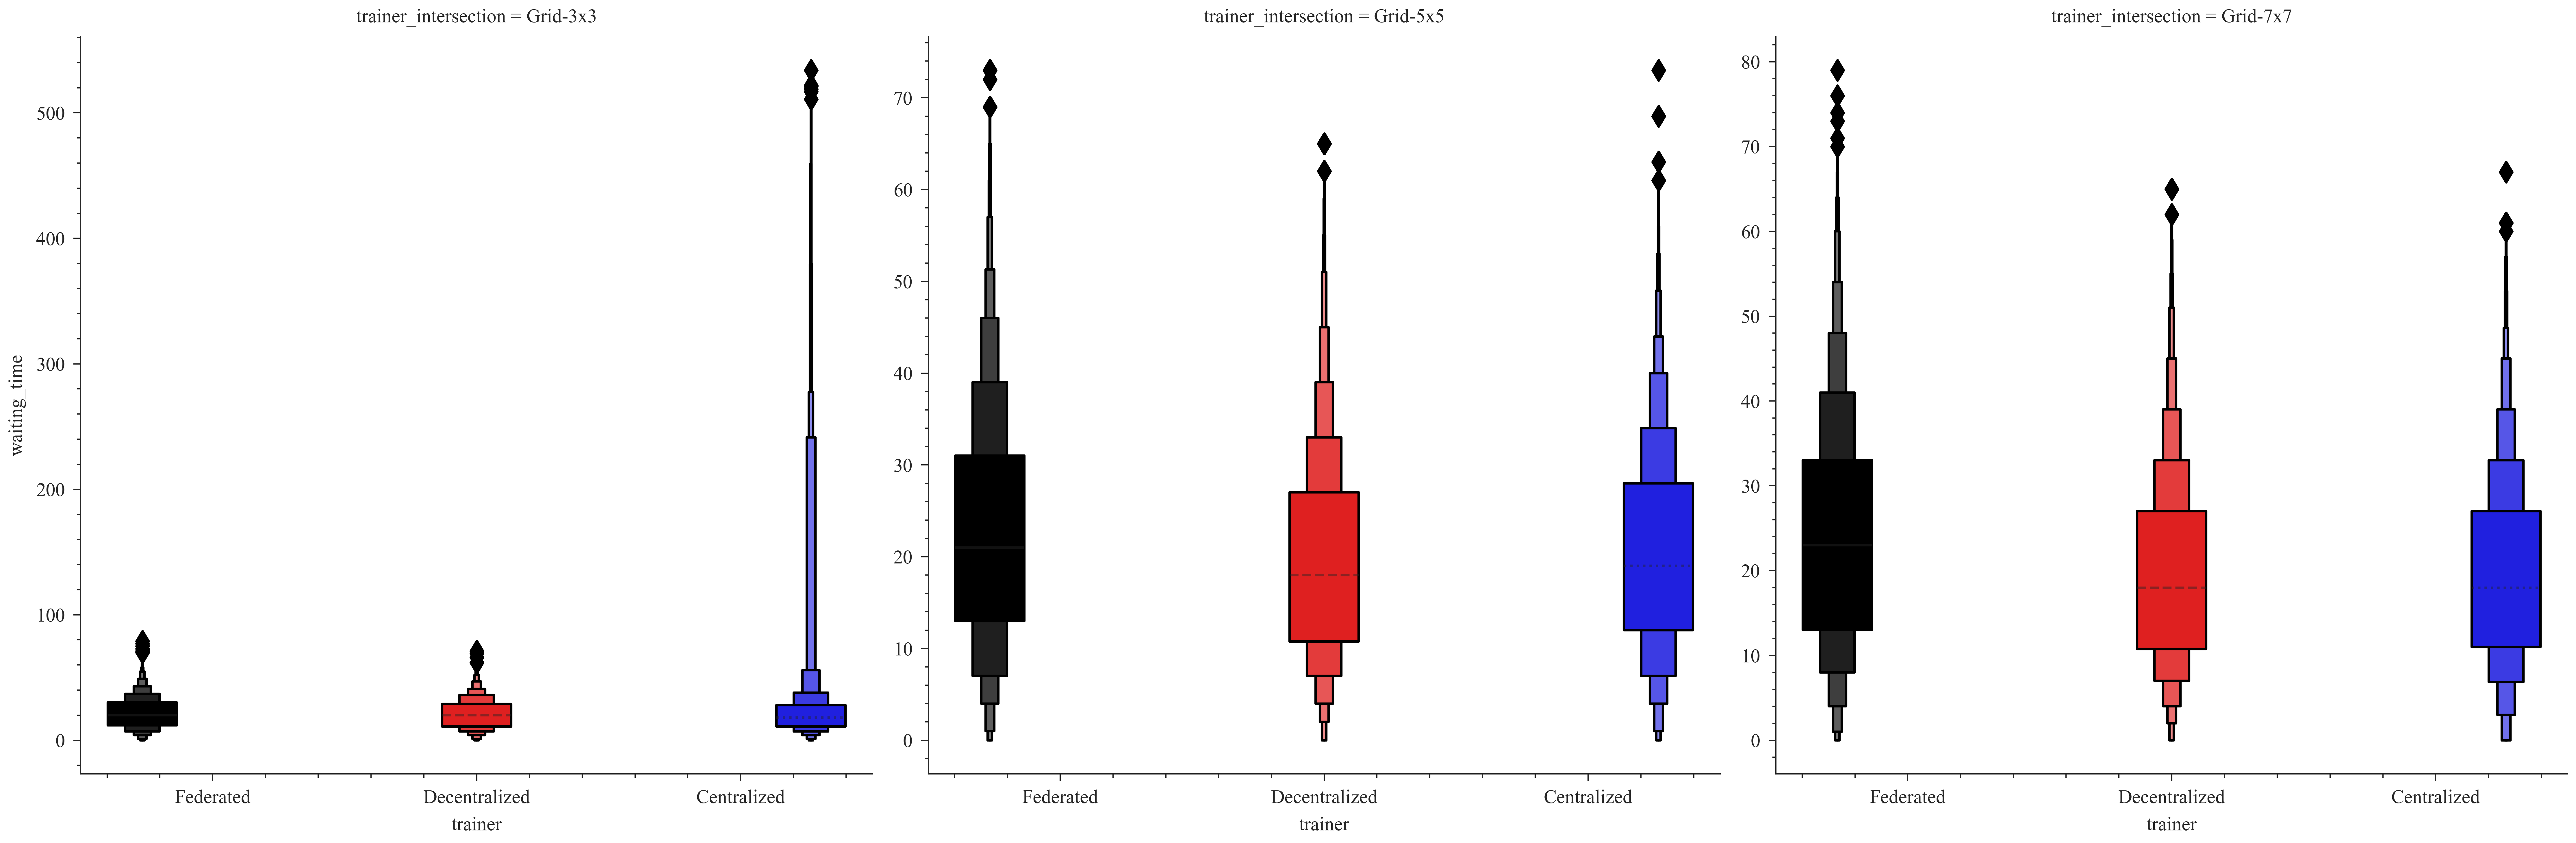

In [95]:
sns.catplot(
    data=trips_df,
    kind="boxen",
    hue="trainer",
    x="trainer",
    y="waiting_time",
    col="trainer_intersection",
    sharey=False,
)
plt.show()